In [2]:
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx

from ABCA7lof2.geneclusters import get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite

###### Processing the genesets

In [2]:
# combine the gsets
p1 = np.load('./raw_data/genesets/BioCarta_2016.npy', allow_pickle=True).item()
#p2 = np.load('./raw_data/genesets/GO_Biological_Process_2023.npy', allow_pickle=True).item()
#p3 = np.load('./raw_data/genesets/HumanCyc_2016.npy', allow_pickle=True).item()
p4 = np.load('./raw_data/genesets/KEGG_2021_Human.npy', allow_pickle=True).item()
p5 = np.load('./raw_data/genesets/Reactome_2022.npy', allow_pickle=True).item()
p6 = np.load('./raw_data/genesets/WikiPathways_2019_Human.npy', allow_pickle=True).item()
#res = {**p1, **p2, **p3, **p4, **p5, **p6}
res = {**p6}#,**p6,**p1}#,**p5}
np.save('./processed_data/genesets/all_paths.npy', res)

In [3]:
pd.DataFrame.from_dict(res, orient='index').to_csv('./processed_data/genesets/all_paths.csv')

##### showing jaccard index for pathway databases

In [2]:
# get pathway gene matrix
mat = get_gene_pathway_matrix('./processed_data/genesets/all_paths.npy')

In [3]:
mat.shape

(472, 6201)

In [4]:
import numba as nb
@nb.njit()
def compute_jaccard(arr1, arr2):
    outer = arr1-arr2
    i_outer = np.sum(outer>0)
    outer_sum = np.sum(np.abs(outer))
    shared = np.sum(arr1)-i_outer
    jaccard = shared/(outer_sum+shared)
    return jaccard

@nb.njit(parallel=True)
def compute_all_jaccard(mat_array):
    N = mat_array.shape[0]
    out = np.empty(shape=(N,N))
    for i in nb.prange(N):
        for j in nb.prange(N):
            out[i,j] = compute_jaccard(mat_array[i], mat_array[j])
    return out

In [7]:
mat_array = np.array(mat)
out = compute_all_jaccard(mat_array)

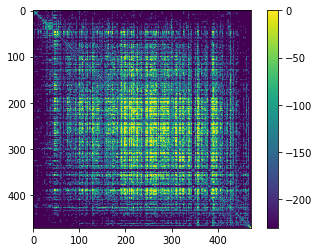

In [8]:
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(out)

o = np.argsort(embedding.ravel())
plt.imshow((np.log(out+1e-100)[o][:,o]), cmap='viridis', vmax=0, vmin=-230)
plt.colorbar()
plt.savefig('./pdf_figures/jaccard_all_paths.png')

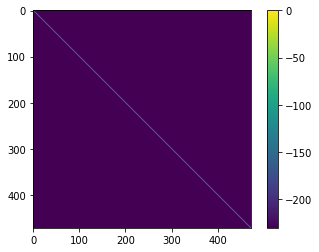

In [9]:
x = np.zeros_like(out)
np.fill_diagonal(x, 1)
plt.imshow((np.log(x+1e-100)), cmap='viridis', vmax=0, vmin=-230)
plt.colorbar()

##### assess consistency across runs

In [14]:
# assign the clusters
from tqdm import tqdm

C = 0
KL_modified = True
random_labels = True
unweighted = True

N=1000
loss = np.empty(N)
clusters = np.empty((N,np.sum(mat_sub.shape)))

for i in tqdm(range(N)):
    frame, loss_temp = get_kernighan_lin_clusters(None, 50, C, KL_modified, random_labels, unweighted, seed=i, no_progress=True, mat=mat_sub)
    frame.columns = ['cluster', 'description', 'is_gene']
    clusters[i] = np.array(frame['cluster'])
    loss[i] = loss_temp

100%|██████████| 1000/1000 [07:10<00:00,  2.32it/s]


In [15]:
@nb.njit(parallel=True)
def compute_jaccard_all_clust(arr1, arr2):
    N = len(np.unique(arr1))
    out = np.empty(shape=(N,N))
    for i in nb.prange(N):
        for j in nb.prange(N):
            i_0 = (arr1==i)#.astype(int)
            j_0 = (arr2==j)#.astype(int)
            out[i,j] = compute_jaccard(i_0, j_0)
    return out

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


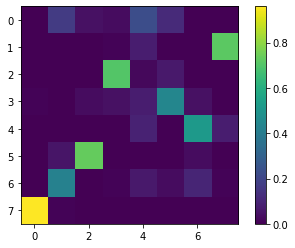

In [16]:
temp = compute_jaccard_all_clust(clusters[5], clusters[1])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis')#, vmax=0, vmin=-230)
plt.colorbar()
plt.savefig('./pdf_figures/example1.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


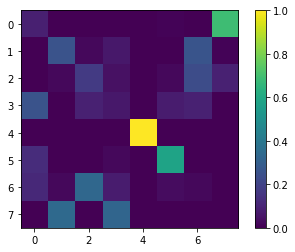

In [17]:
temp = compute_jaccard_all_clust(clusters[10], clusters[11])
T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis')#, vmax=0, vmin=-230)
plt.colorbar()
plt.savefig('./pdf_figures/example2.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


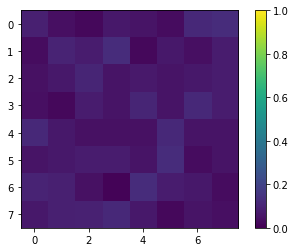

In [18]:
temp = compute_jaccard_all_clust(np.random.permutation(clusters[5]), clusters[1])

T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis', vmax=1, vmin=0)
plt.colorbar()
plt.savefig('./pdf_figures/example1_baseline.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


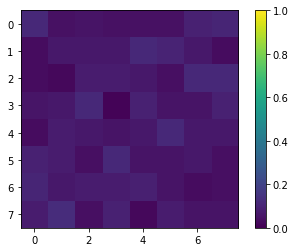

In [19]:
temp = compute_jaccard_all_clust(np.random.permutation(clusters[10]), clusters[11])

T = temp
embedding = SpectralEmbedding(n_components=1, affinity='precomputed')
embedding = embedding.fit_transform(1-T)

o = np.argsort(embedding.ravel())
plt.imshow(T[o][:,o], cmap='viridis', vmax=1, vmin=0)
plt.colorbar()
plt.savefig('./pdf_figures/example2_baseline.pdf')

In [22]:
from scipy.stats import entropy

In [20]:
#@nb.njit(parallel=True)
def get_entropies(clusters, ent):
    index = 0
    for i in tqdm(range(clusters.shape[0])):
        for j in range(clusters.shape[0]):
            temp = compute_jaccard_all_clust((clusters[i]), (clusters[j]))
            ent[index] = entropy(temp, axis=1)
            index+=1

#@nb.njit(parallel=True)
def get_entropies_rand(clusters, ent):
    index = 0
    for i in tqdm(range(clusters.shape[0])):
        for j in range(clusters.shape[0]):
            temp = compute_jaccard_all_clust((clusters[i]), np.random.permutation(clusters[j]))
            ent[index] = entropy(temp, axis=1)
            index+=1

In [23]:
N = 50
n = clusters[:N].shape[0]*clusters[:N].shape[0]
ent = np.empty((n, len(np.unique(clusters[:N]))))
get_entropies(clusters[:N], ent)

100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


In [24]:
ent_rand = np.ones((n, len(np.unique(clusters[:N]))))
get_entropies_rand(clusters[:N], ent_rand)


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


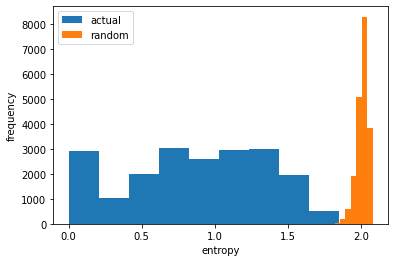

In [29]:
plt.hist(ent.ravel(), label='actual')
plt.hist(ent_rand.ravel(), label='random')
plt.ylabel('frequency')
plt.xlabel('entropy')
plt.legend()
plt.savefig('./pdf_figures/entropy.pdf')


#### plot loss by method

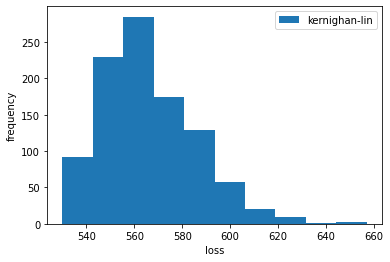

In [33]:
plt.hist(loss, label='kernighan-lin')
plt.ylabel('frequency')
plt.xlabel('loss')
plt.legend()
plt.savefig('./pdf_figures/loss.pdf')


#### KL clustering by major celltype

In [388]:
def plot_edges(layout, graph, pos):
    for e_from, e_to in list(graph.edges):
        ss = np.array([layout[e_from], layout[e_to]])
        if graph.get_edge_data(e_from, e_to)['weight'] >=0.5:
            plt.plot(*(ss.T), c='black', alpha=0.1)
        
def plot_nodes(graph, selected_names, pos, cur_labels, unique_clusters, colors, S):
    #ipdb.set_trace()
    #ipdb.set_trace()
    types = np.array([graph.nodes[node]['type'] for node in graph.nodes])
    names = np.array([graph.nodes[node]['name'] for node in graph.nodes])  
    for i, cluster_name in enumerate(unique_clusters):
        index = cur_labels==cluster_name
        if np.sum(index)==0:
            continue
        plot_single_cluster(colors[i], pos[index], types[index], names[index], cluster_name, selected_names, S)

def plot_nodes_continuous(graph, selected_names, pos, cur_labels, unique_clusters, colors, S):
    #ipdb.set_trace()
    types = np.array([graph.nodes[node]['type'] for node in graph.nodes])
    names = np.array([graph.nodes[node]['name'] for node in graph.nodes])  
    for i, score in enumerate(cur_labels):
        plt.scatter(pos[i][0], pos[i][1], color=colors[i], zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)

        
def plot_single_cluster(col, pos_curr, types_curr, names_curr, cluster_name, selected_names, S):
    props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=col)
    x, y = np.mean(pos_curr, axis = 0)
    x-=0.2
    plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
    plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')
    
    labels = ''
    n=0
    
    for i, name in enumerate(names_curr):
        if name in selected_names:
            #labels+='\n'+name
            #n+=1
            plt.text(pos_curr[i,0], pos_curr[i,1], name,  bbox=props, c = col, fontsize = 10, zorder=6, style = "italic")
            
    #plt.text(x, y, labels,  bbox=props, c = col, fontsize = 10, zorder=6, style = "italic")
    plt.text(x, y+(0.045*(n+1)), cluster_name,  bbox=props, c = col, fontsize = 15, zorder=6, weight = "bold")

def get_le_clusters(le_path, fgsea, celltype, mat, seed, Ngenes):
    leading_edge = pd.read_csv(le_path, index_col=0)
    P = set(fgsea[fgsea['x']==celltype]['pathway'])
    S = set(leading_edge['gene'])

    col_index = np.where([x in S for x in mat.columns])[0]
    mat_sub = mat.iloc[:,col_index]

    path_index = (np.sum(mat_sub, axis=1)>4)
    mat_sub = mat_sub.loc[path_index]
    mat_sub = mat_sub.loc[:,np.sum(mat_sub, axis=0)>0]

    # assign the clusters

    C = 0
    KL_modified = True
    random_labels = True
    unweighted = True

    frame, loss_temp = get_kernighan_lin_clusters(None, Ngenes, C, KL_modified, random_labels, unweighted, seed=seed, no_progress=False, mat=mat_sub)
    frame.columns = ['cluster', 'description', 'is_gene']
    return frame, mat_sub

def get_layout(frame, mat_sub, it, k=15):
    cols = np.array(frame['cluster'][frame['is_gene']])
    g_names  = np.array(frame['description'][frame['is_gene']])
    rows = np.array(frame['cluster'][np.invert(frame['is_gene'])])
    p_names  = np.array(frame['description'][np.invert(frame['is_gene'])])

    matrix = np.array(mat_sub)

      # set up the graph
    N = len(rows) + len(cols)
    full_matrix = np.zeros((N, N), dtype=matrix.dtype)
    full_matrix[:matrix.shape[0],matrix.shape[0]:] = matrix
    graph = networkx.from_numpy_array(full_matrix)
    cluster_labels = np.concatenate([rows, cols])
    node_names = np.concatenate([p_names, g_names])
    for i, l in enumerate(cluster_labels):
        graph.nodes[i]['cluster_id'] = l
        graph.nodes[i]['type'] = i < matrix.shape[0]
        graph.nodes[i]['name'] = node_names[i]

    for e_i in range(N):
        for e_j in range(e_i + 1, N):
            if graph.nodes[e_i]['cluster_id'] == graph.nodes[e_j]['cluster_id'] and not graph.has_edge(e_i, e_j):
                graph.add_edge(e_i, e_j, weight=0.05)

    components = list(networkx.connected_components(graph))
    unique_clusters = np.unique(np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes]))

    unique_clusters = np.unique(frame['cluster'])
    cm = plt.cm.get_cmap('tab20')
    colors = [cm(int(x)) for x in range(len(unique_clusters))]

    cur_labels = np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes])
    layout = networkx.spring_layout(graph,k=k, iterations=it, weight='weight')
    pos = np.array(list(layout.values()))

    return graph, pos, cur_labels, unique_clusters, colors, layout

def plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path):
    plt.figure(figsize = (7,5))

    # plot by cluster color
    np.save('./processed_data/single_cell/ex_pathway_coords.csv', pos)
    plot_edges(layout, graph, pos)
    plot_nodes(graph, [], pos, cur_labels, unique_clusters, colors, 100)
    a = plt.gca()
    a.axis('off')
    plt.savefig(out_path+'_network.png', bbox_inches="tight")

def get_representative_name_per_cluster(bipartite_mat, colnames_mat, rownames_mat, description_table, cluster):
    genes = set(description_table.loc[description_table['is_gene']&(description_table['cluster']==cluster)]['description'])
    paths = set(description_table.loc[np.invert(description_table['is_gene'])&(description_table['cluster']==cluster)]['description'])
    if len(paths)==0:
        return 'C.'+str(cluster), np.nan, np.nan, np.nan
    else:
        index_col = [x in genes for x in colnames_mat]
        index_row = [x in paths for x in rownames_mat]
        
        #ipdb.set_trace()
    
        sum_internal = np.sum(bipartite_mat[index_row][:,index_col], axis=1)
        sum_external = np.sum(bipartite_mat[index_row][:,np.invert(index_col)], axis=1)
        sum_ratio = sum_internal/(sum_external+sum_internal)
        S = np.argsort(-1*sum_ratio)[:5]
        rep_name = rownames_mat[index_row][S]

        return rep_name #'C.'+str(cluster), rep_name.split(' (')[0], sum_internal[S], sum_internal[S]

# get rep names


def plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path):
    import re
    from adjustText import adjust_text
    colnames = np.array(mat_sub.columns)
    rownames = np.array(mat_sub.index)

    out = [get_representative_name_per_cluster(np.array(mat_sub), colnames, rownames, frame, x) for x in np.unique(frame['cluster'])]

    plt.figure(figsize = (1,1))
    a = plt.gca()
    a.axis('off')
    texts = []
    y = 0
    for i, cluster_name in enumerate(unique_clusters):
            index = cur_labels==cluster_name
            x, y = np.mean(pos[index], axis=0)

            props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=colors[i])
            temp = [re.split(r' [(]GO|WP| R-',x)[0] for x in out[i]]
            T = ('\n').join(temp)
            plt.text(0, 0, T,  bbox=props, c =colors[i], fontsize = 10, style = "italic")

            a = plt.gca()
            a.axis('off')
            plt.savefig(out_path + str(i) + '.png', bbox_inches="tight")
            plt.figure()
            #y+=0.01

    #adjust_text(texts)

def plot_sub_graph(cluster, frame, celltype, out_path, layout, graph, pos, cur_labels, scores, mat_sub, figsize0, figsize1, figsize2):
    
    unique_clusters = np.unique(frame['cluster'])
    cm = plt.cm.get_cmap('tab20')
    colors = [cm(int(x)) for x in range(len(unique_clusters))]
    colors2 = list((colors[cluster]))
    #colors2 = list((colors[cluster],(0, 0, 0, 0.17)))
    
    plt.figure(figsize = figsize0)
    cur_labels_copy = cur_labels.copy()
    cur_labels_copy[cur_labels_copy!=cluster]=9

    # plot by cluster color
    pos = np.array(list(layout.values()))
    plot_edges(layout, graph, pos)
    #plot_nodes(graph, [], pos, cur_labels_copy,list([cluster,9]), colors2, 100)
    index = cur_labels==cluster
    plot_nodes(graph.subgraph(np.where(np.invert(index))[0]), [], pos[np.invert(index)], cur_labels[np.invert(index)],list(unique_clusters[unique_clusters!=cluster]), [(0, 0, 0, 0.17) for x in range(len(unique_clusters))], 100)
    plot_nodes(graph.subgraph(np.where(index)[0]), [], pos[index], cur_labels[index],list([cluster]), list([colors[cluster]]), 100)
    
    a = plt.gca()
    a.axis('off')
    plt.savefig(out_path+str(cluster)+'_highlighted.png')
    
    # plot the genes
    temp = frame[frame['cluster']==cluster]
    temp = scores.loc[temp['description'][temp['is_gene']]]
    #temp = temp[np.abs(temp[celltype])>1]
    temp['gene'] = temp.index
    temp['score'] = np.abs(temp[celltype])
    temp = temp.sort_values(by='score', ascending=False)
    temp['score'] = (temp[celltype])
    temp = temp[:15]
    temp = temp.sort_values(by='score', ascending=False)
    
    #temp['score'] = (temp[celltype])
    #temp=temp.sort_values(by='score', ascending = False)

    plt.figure(figsize = figsize1)
    sns.barplot(data=temp, x=celltype, y='gene', color=colors[cluster])

    plt.xlabel('-log10(p-value)*sign(log2(FC))')
    plt.ylabel('')
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(out_path+str(cluster)+'_genes.png', bbox_inches="tight")
    
    
    # plot the pathways
    temp = frame[frame['cluster']==cluster]
    T = mat_sub[temp['description'][temp['is_gene']]].loc[temp['description'][np.invert(temp['is_gene'])]]
    temp = np.matmul(T,scores.loc[T.columns][celltype])
    temp = pd.DataFrame(temp)
    
    index = []
    for i in temp.index:
        x = np.array(mat_sub.columns)[np.array(mat_sub.loc[i]==1)]
        inside = len(x[[i in set(frame[frame['cluster']==cluster]['description']) for i in x]])
        outside = len(x[[i in set(frame[frame['cluster']!=cluster]['description']) for i in x]])
        index.append(inside>=outside)
    
    temp = temp[index]
    temp['pathway'] = [x.split(' WP')[0] for x in np.array(temp.index)]
    temp['score'] = np.abs(temp[0])
    temp = temp.sort_values(by='score', ascending=False)
    temp['score'] = (temp[0])
    temp = temp[:15]
    temp = temp.sort_values(by='score', ascending=False)
    plt.figure(figsize = figsize2)
    sns.barplot(data=temp, x='score', y='pathway', color=colors[cluster])
    plt.xlabel('score')
    plt.ylabel('')
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(out_path+str(cluster)+'_bars.png', bbox_inches="tight")

def plot_scores(frame, scores, celltype, unique_clusters, out_path):
    # plot scores
    g_names  = np.array(frame['description'][frame['is_gene']])

    SCORES = np.array(scores.loc[g_names][celltype])

    score_sum = np.array([np.sum(np.abs(SCORES[frame['cluster'][frame['is_gene']]==i])) for i in unique_clusters])
    plt.figure(figsize = (4,3))

    plt.bar(height=score_sum[np.argsort(-1*score_sum)], x = [x.astype(str) for x in unique_clusters[np.argsort(-1*score_sum)]], color = np.array(colors)[np.argsort(-1*score_sum)])
    plt.ylabel('ABCA7 LoF perturbation score')
    plt.xlabel('Gene Cluster')
    plt.savefig(out_path+'_bars.png', bbox_inches="tight")
    return score_sum

[(0, 0, 0, 0.17),
 (0, 0, 0, 0.17),
 (0, 0, 0, 0.17),
 (0, 0, 0, 0.17),
 (0, 0, 0, 0.17),
 (0, 0, 0, 0.17),
 (0, 0, 0, 0.17),
 (0, 0, 0, 0.17),
 (0, 0, 0, 0.17)]

In [3]:
# get pathway gene matrix
mat = get_gene_pathway_matrix('./processed_data/genesets/all_paths.npy')

### Excitatory neurons

4it [00:00,  4.93it/s, tot_impr=871, last_impr=0, loss=759]  
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


array([11.40204795, 37.31346988, 43.89306652, 10.04383509, 25.01510245,
       45.08524364, 25.12401754, 30.42215088, 20.92433532])

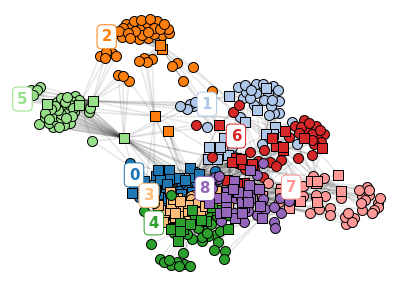

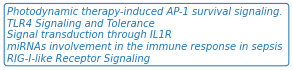

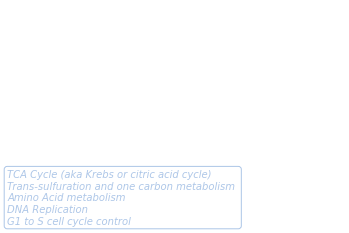

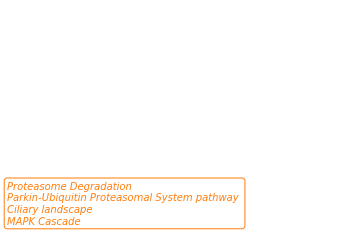

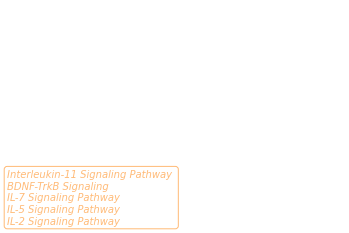

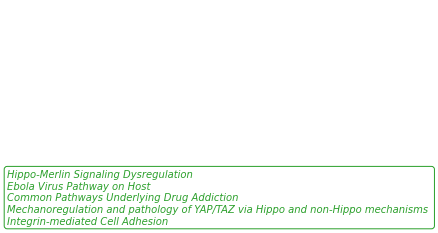

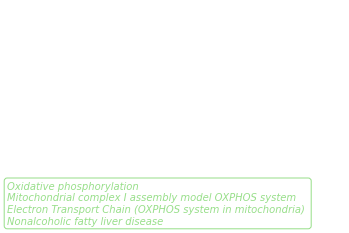

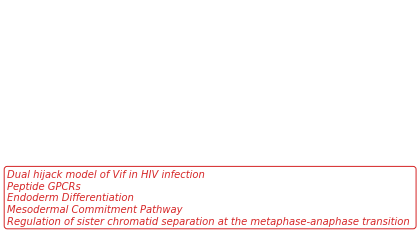

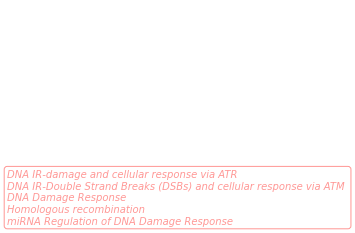

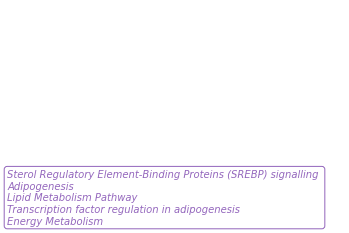

<Figure size 432x288 with 0 Axes>

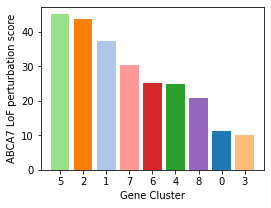

In [390]:
# get clusters for Ex
out_path = './pdf_figures/LE_clust_ex_names' 
leading_edge = './processed_data/for_plotting/leading_edge_EX.csv'
fgsea = pd.read_csv( './processed_data/for_plotting/fgsea_out.csv', index_col=0)
frame, mat_sub = get_le_clusters(leading_edge, fgsea, 'Ex', mat, 5, 50)

# plot graph
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, 10000, 10)
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path)

# plot scores
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
plot_scores(frame, scores, 'Ex', unique_clusters, out_path)

/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:172: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


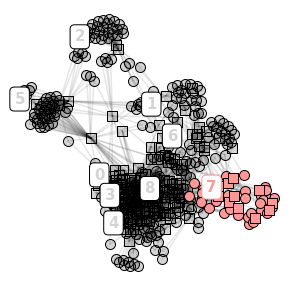

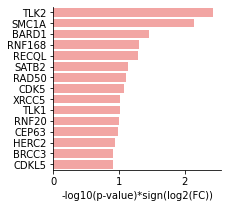

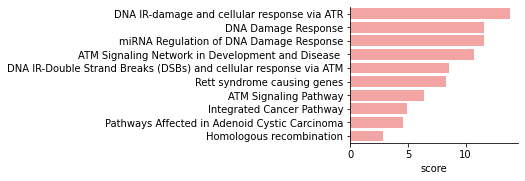

In [401]:
plot_sub_graph(7, frame, 'Ex', out_path, layout, graph, pos, cur_labels, scores, mat_sub, (5,5), (3,3), (3,2.5))

5it [00:00, 29.81it/s, tot_impr=323, last_impr=0, loss=421]
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


array([15.89923111,  2.35222881,  8.83789606,  7.04142359, 10.56073184,
        7.4025818 , 10.25139499, 15.13183824,  5.48153042])

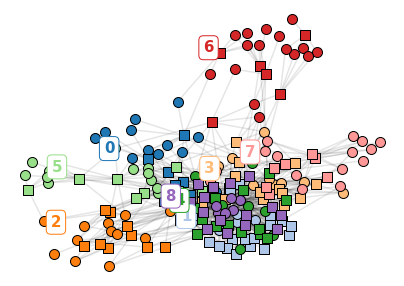

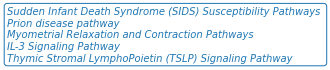

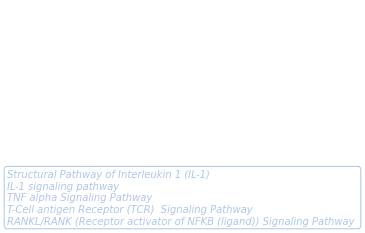

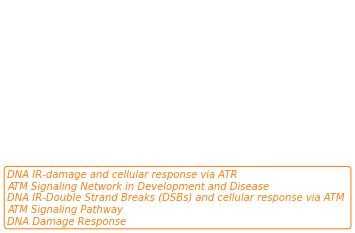

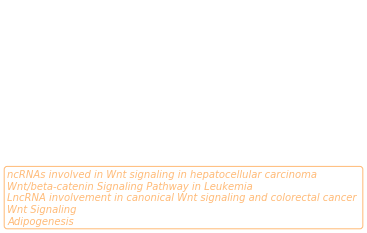

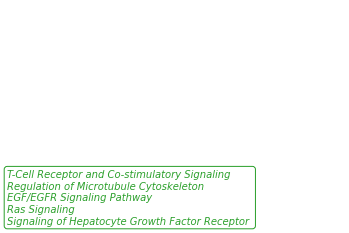

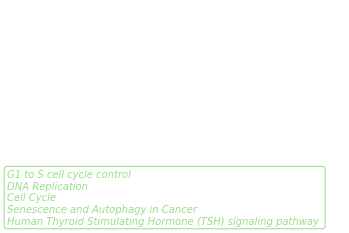

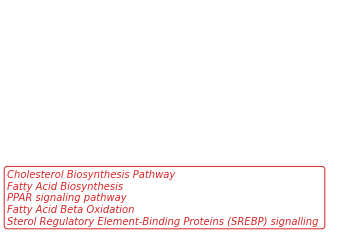

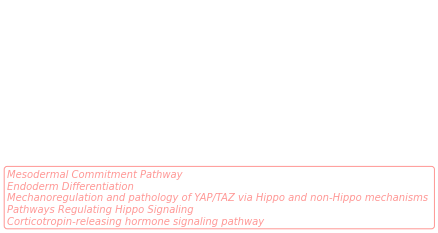

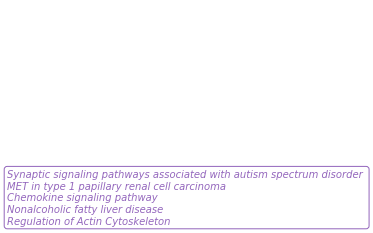

<Figure size 432x288 with 0 Axes>

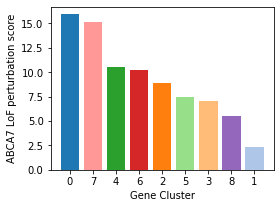

In [407]:
# get clusters for Oli
out_path = './pdf_figures/LE_clust_oli_names' 
leading_edge = './processed_data/for_plotting/leading_edge_Oli.csv'
fgsea = pd.read_csv( './processed_data/for_plotting/fgsea_out.csv', index_col=0)
frame, mat_sub = get_le_clusters(leading_edge, fgsea, 'Oli', mat, 5, 22)

# plot graph
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, 10000, 10)
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path)

# plot scores
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
plot_scores(frame, scores, 'Oli', unique_clusters, out_path)

3it [00:00, 10.06it/s, tot_impr=533, last_impr=0, loss=679]  
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


array([17.19836034, 16.9591581 ,  9.07235952,  6.27051119, 17.94577753,
       21.78363836, 12.3894696 , 12.1289425 ,  8.78549164, 15.58749134])

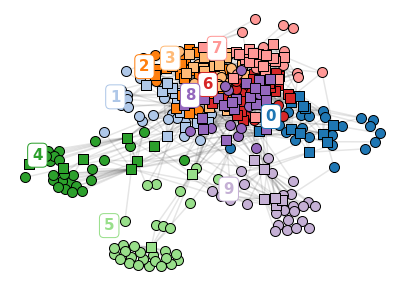

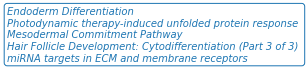

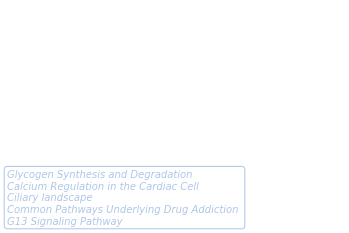

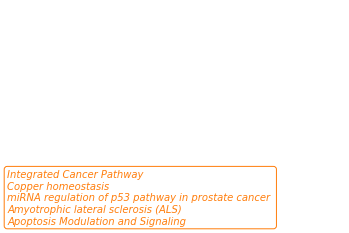

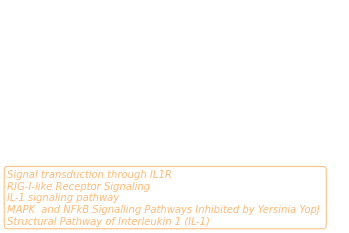

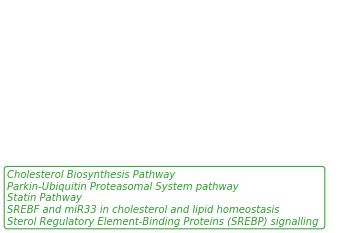

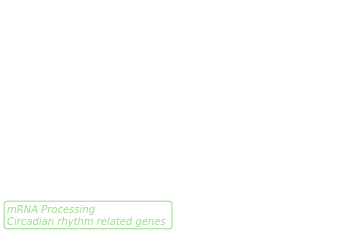

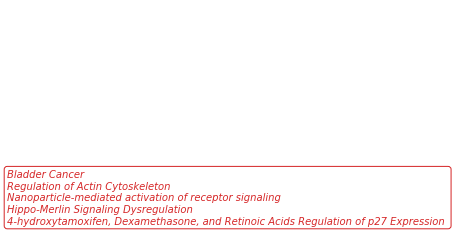

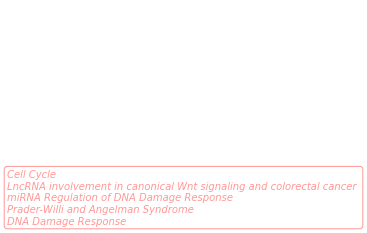

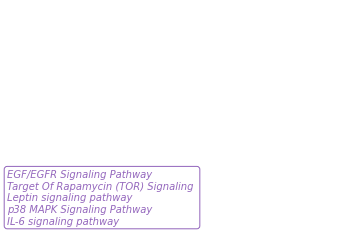

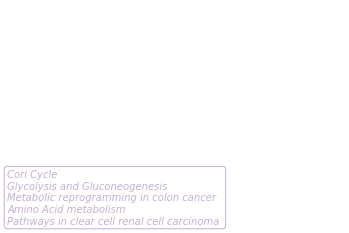

<Figure size 432x288 with 0 Axes>

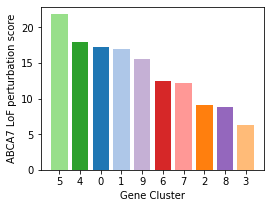

In [412]:
# get clusters for Oli
out_path = './pdf_figures/LE_clust_ast_names' 
leading_edge = './processed_data/for_plotting/leading_edge_Ast.csv'
fgsea = pd.read_csv( './processed_data/for_plotting/fgsea_out.csv', index_col=0)
frame, mat_sub = get_le_clusters(leading_edge, fgsea, 'Ast', mat, 5, 35)

# plot graph
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, 10000, 10)
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path)

# plot scores
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
plot_scores(frame, scores, 'Ast', unique_clusters, out_path)

3it [00:00, 18.34it/s, tot_impr=409, last_impr=0, loss=617] 
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


array([22.61820179, 22.42839279,  9.46878922, 23.74771621,  9.721829  ,
       11.73068264,  5.84510211, 13.84057432,  8.70517637])

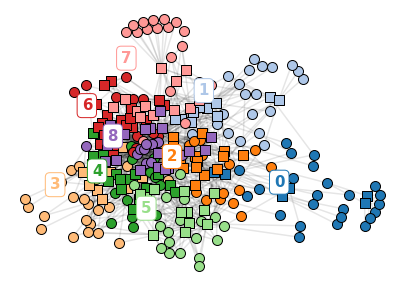

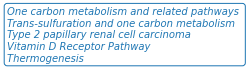

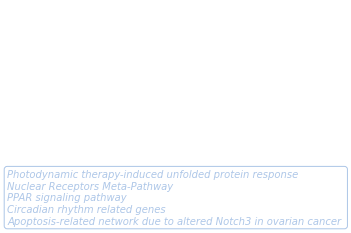

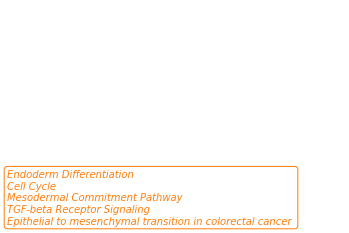

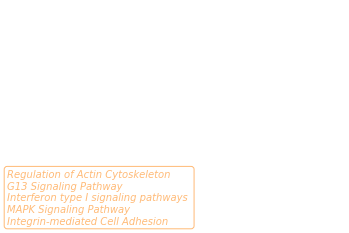

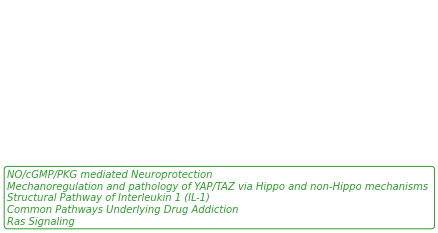

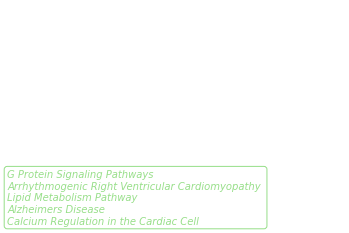

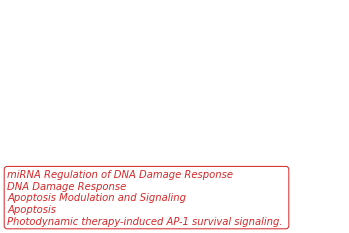

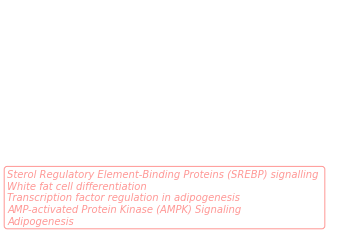

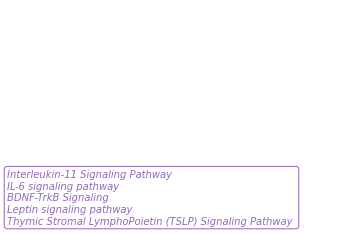

<Figure size 432x288 with 0 Axes>

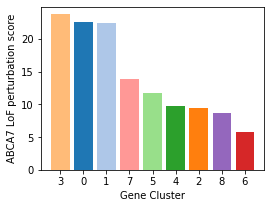

In [416]:
# get clusters for Oli
out_path = './pdf_figures/LE_clust_mic_names' 
leading_edge = './processed_data/for_plotting/leading_edge_Mic.csv'
fgsea = pd.read_csv( './processed_data/for_plotting/fgsea_out.csv', index_col=0)
frame, mat_sub = get_le_clusters(leading_edge, fgsea, 'Mic', mat, 5, 30)

# plot graph
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, 10000, 10)
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path)

# plot scores
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
plot_scores(frame, scores, 'Mic', unique_clusters, out_path)

3it [00:00, 32.63it/s, tot_impr=296, last_impr=0, loss=198]
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3960488065.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


array([10.05525553, 14.16082091, 14.52612721,  6.80170151, 15.22304425,
       13.68686616,  5.56743488, 15.80974391, 11.53598373])

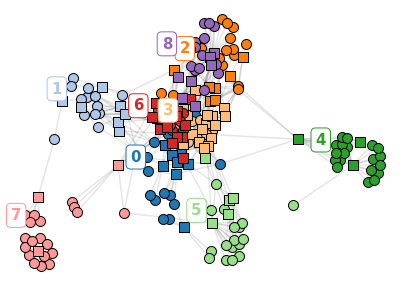

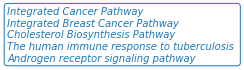

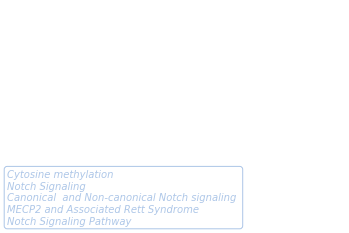

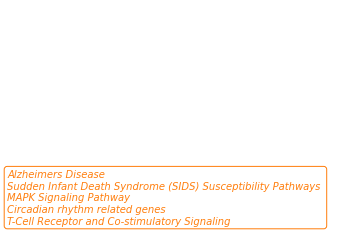

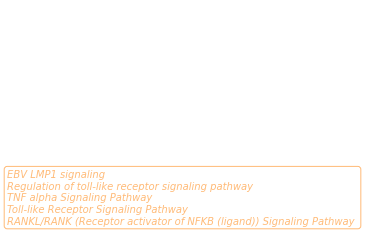

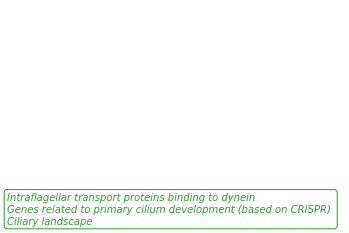

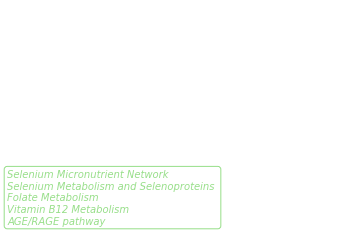

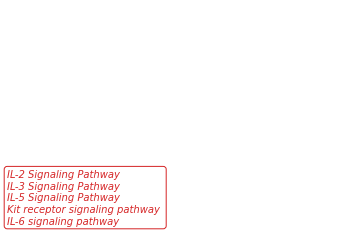

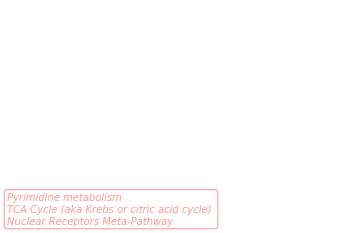

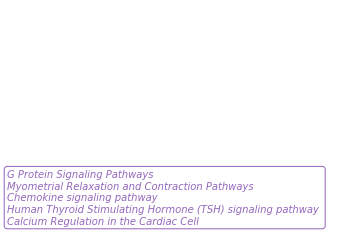

<Figure size 432x288 with 0 Axes>

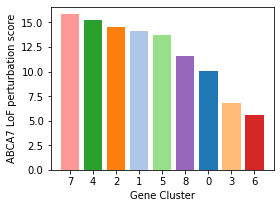

In [425]:
# get clusters for Oli
out_path = './pdf_figures/LE_clust_opc_names' 
leading_edge = './processed_data/for_plotting/leading_edge_Opc.csv'
fgsea = pd.read_csv( './processed_data/for_plotting/fgsea_out.csv', index_col=0)
frame, mat_sub = get_le_clusters(leading_edge, fgsea, 'Opc', mat, 5, 22)

# plot graph
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, 10000, 10)
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path)

# plot scores
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
plot_scores(frame, scores, 'Opc', unique_clusters, out_path)

#### below is scarp

(-0.8426013413245989,
 1.087742921015457,
 -0.7429114796003853,
 0.895499805792993)

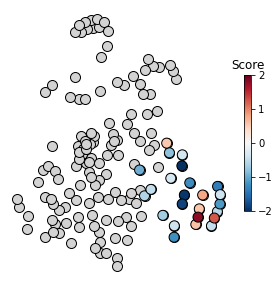

In [419]:
plt.figure(figsize = (5,5))
index = np.invert([graph.nodes[x]['type'] for x in graph.nodes])
clust_id = np.array([graph.nodes[x]['cluster_id'] for x in graph.nodes])

names = np.array([graph.nodes[x]['name'] for x in graph.nodes])

index2 = index&(clust_id==0)
names_g = names[index2]
S = np.array(scores.loc[names_g]['Mic'])

plt.scatter(pos[index,0], pos[index,1], color='lightgrey', s=100, edgecolor="black", linewidth=1)
plt.scatter(pos[index2,0], pos[index2,1], c=S, cmap='RdBu_r', vmin= -2, vmax=2,zorder=5, s=100, edgecolor="black", linewidth=1)
clb = plt.colorbar(shrink=0.5)
clb.ax.set_title('Score')

a = plt.gca()
a.axis('off')

In [291]:
x = np.array(mat_sub.columns)[np.array(mat_sub.loc['DNA Damage Response (only ATM dependent) WP710']==1)]
inside = len(x[[i in set(frame[frame['cluster']==8]['description']) for i in x]])
outside = len(x[[i in set(frame[frame['cluster']!=8]['description']) for i in x]])

In [294]:
inside>outside

False

/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/358784804.py:170: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/358784804.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/358784804.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


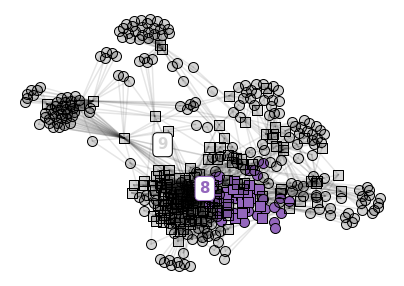

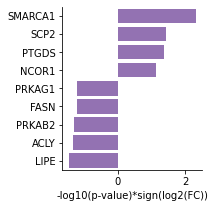

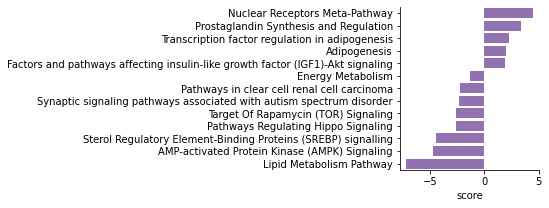

<Axes: xlabel='score', ylabel='pathway'>

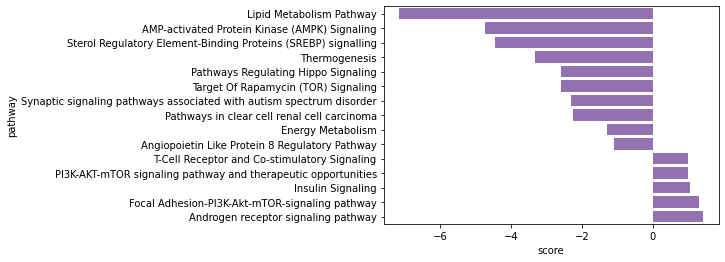

In [264]:
temp = frame[frame['cluster']==8]
T = mat_sub[temp['description'][temp['is_gene']]].loc[temp['description'][np.invert(temp['is_gene'])]]
temp = np.matmul(T,scores.loc[T.columns]['Ex'])
temp = pd.DataFrame(temp)
temp['pathway'] = [x.split(' WP')[0] for x in np.array(temp.index)]
temp['score'] = np.abs(temp[0])
temp = temp.sort_values(by=0, ascending=True)
temp['score'] = (temp[0])

sns.barplot(data=temp[:15], x='score', y='pathway', color=colors[8])

In [265]:
scores.loc[T.columns]['Ex']

ACLY       -1.328177
CBR1        0.674081
FASN       -1.205042
IRS1        0.321742
IRS2        0.646138
LIPE       -1.457198
MAP3K4      0.785275
NCOR1       1.142460
PDK1        0.718132
PIK3C3      0.542652
PIK3R4      0.418522
PNPLA2     -0.568327
PPARG       0.689626
PPARGC1A    0.609807
PPP2R5E     0.976315
PRKAA2     -0.497291
PRKAB2     -1.307585
PRKAG1     -1.205013
PRKAG2      0.408819
PTEN        0.289927
PTGDS       1.378495
SCP2        1.441692
SMARCA1     2.312019
Name: Ex, dtype: float64

In [262]:
scores.loc[T.columns[np.array(T.loc['Lipid Metabolism Pathway WP3965'])==1]]['Ex']

ACLY     -1.328177
FASN     -1.205042
LIPE     -1.457198
PNPLA2   -0.568327
PRKAA2   -0.497291
PRKAB2   -1.307585
PRKAG1   -1.205013
PRKAG2    0.408819
Name: Ex, dtype: float64

In [ ]:
   # plot the pathways
    temp = frame[frame['cluster']==cluster]
    T = mat_sub[temp['description'][temp['is_gene']]].loc[temp['description'][np.invert(temp['is_gene'])]]
    temp = np.matmul(T,scores.loc[T.columns][celltype])
    temp = pd.DataFrame(temp)
    temp['pathway'] = [x.split(' WP')[0] for x in np.array(temp.index)]
    temp = temp.sort_values(by=0, ascending=False)
    temp['score'] = temp[0]
    
    plt.figure(figsize = (2.5,3))
    sns.barplot(data=temp[:15], x='score', y='pathway', color=colors[cluster])
    plt.xlabel('score')
    plt.ylabel('')
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(out_path+str(cluster)+'_bars.png', bbox_inches="tight")


/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3620857364.py:170: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3620857364.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/3620857364.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


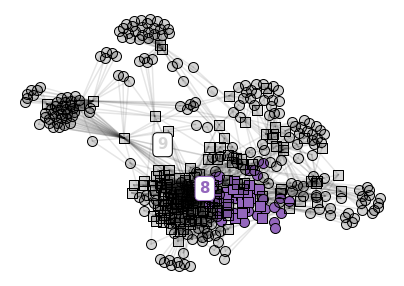

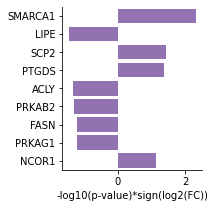

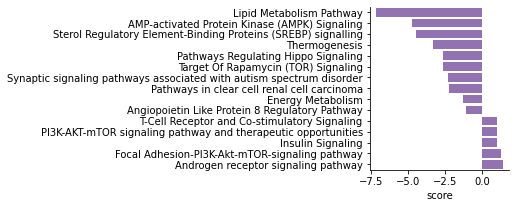

In [241]:
np.sum(S>0)

16

(-1.0987696353161458,
 1.0754000260478953,
 -1.063270456669486,
 1.0913165861447491)

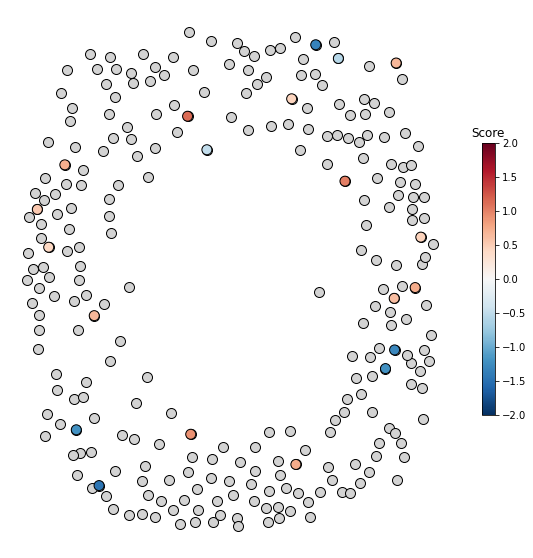

In [252]:
plt.figure(figsize = (10,10))
index = np.invert([graph.nodes[x]['type'] for x in graph.nodes])
clust_id = np.array([graph.nodes[x]['cluster_id'] for x in graph.nodes])

names = np.array([graph.nodes[x]['name'] for x in graph.nodes])

index2 = index&(clust_id==3)
names_g = names[index2]
S = np.array(scores.loc[names_g]['Ex'])

plt.scatter(pos[index,0], pos[index,1], color='lightgrey', s=100, edgecolor="black", linewidth=1)
plt.scatter(pos[index2,0], pos[index2,1], c=S, cmap='RdBu_r', vmin= -2, vmax=2,zorder=5, s=100, edgecolor="black", linewidth=1)
clb = plt.colorbar(shrink=0.5)
clb.ax.set_title('Score')

a = plt.gca()
a.axis('off')

### Oligodendrocytes

4it [00:00, 30.06it/s, tot_impr=322, last_impr=0, loss=400] 
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/1482175200.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/1482175200.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/1482175200.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


array([13.44567318,  3.16860495,  9.80349156,  8.64967145, 11.61375331,
        8.77005511,  7.14709617, 20.36051114])

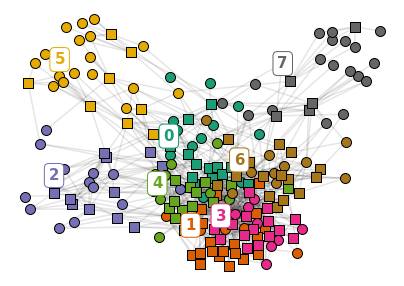

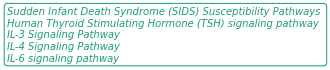

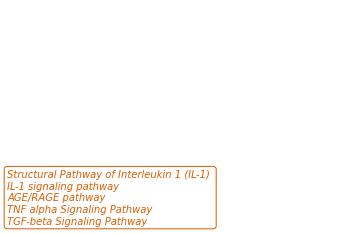

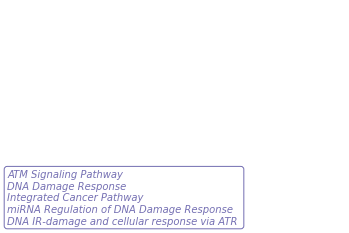

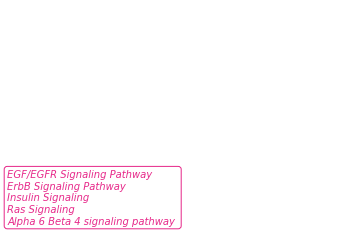

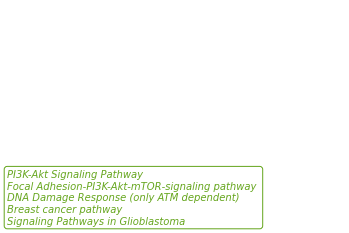

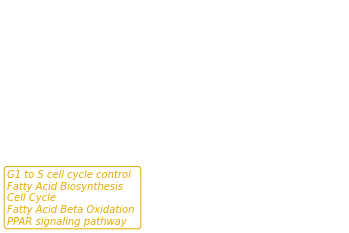

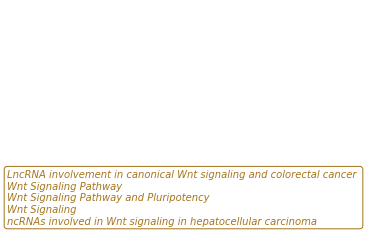

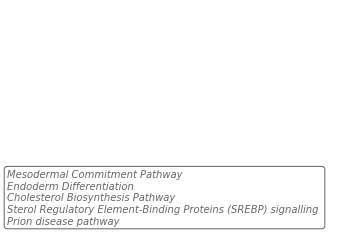

<Figure size 432x288 with 0 Axes>

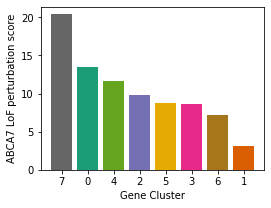

In [134]:
# get clusters for Oli
out_path = './pdf_figures/LE_clust_oli_' 
leading_edge = './processed_data/for_plotting/leading_edge_Oli.csv'
fgsea = pd.read_csv( './processed_data/for_plotting/fgsea_out.csv', index_col=0)
frame, mat_sub = get_le_clusters(leading_edge, fgsea, 'Oli', mat, 5, 25)

# plot graph
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, 10000, 15)
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path)

# plot scores
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
plot_scores(frame, scores, 'Oli', unique_clusters, out_path)

In [135]:
index = np.invert([graph.nodes[x]['type'] for x in graph.nodes])
names = np.array([graph.nodes[x]['name'] for x in graph.nodes])
names_g = names[index]
S = np.array(scores.loc[names_g]['Oli'])
plt.scatter(pos[index,0], pos[index,1], c=S, cmap='RdBu_r', zorder=5, s=100, edgecolor="black", linewidth=1)
plt.colorbar()

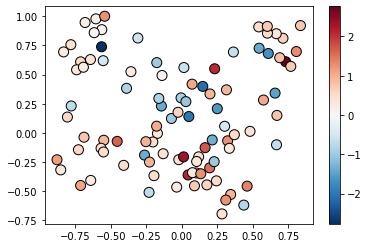

3it [00:00,  9.68it/s, tot_impr=570, last_impr=0, loss=593]  
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/1482175200.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/1482175200.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23632928.0.0/ipykernel_242886/1482175200.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


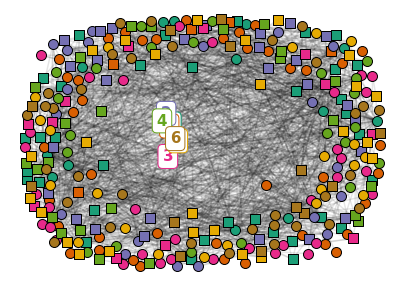

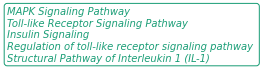

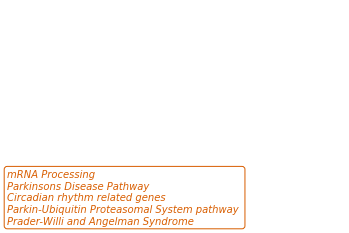

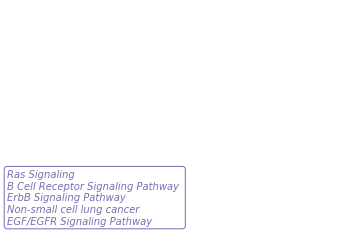

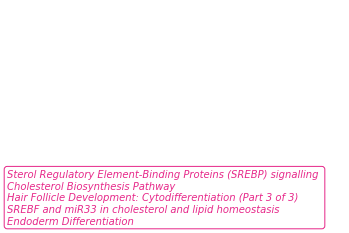

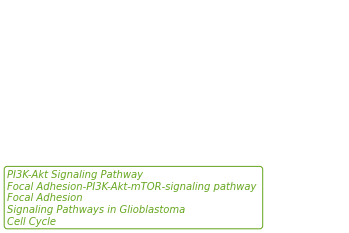

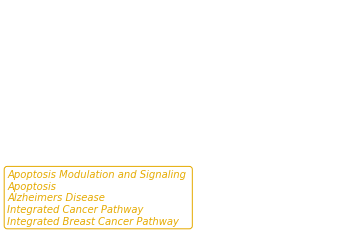

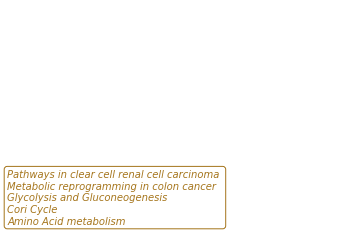

<Figure size 432x288 with 0 Axes>

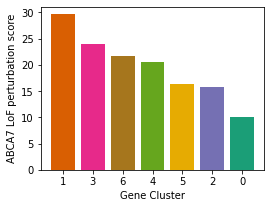

In [71]:
# get clusters for Ast
out_path = './pdf_figures/LE_clust_ast_' 
leading_edge = './processed_data/for_plotting/leading_edge_Ast.csv'
fgsea = pd.read_csv( './processed_data/for_plotting/fgsea_out.csv', index_col=0)
frame, mat_sub = get_le_clusters(leading_edge, fgsea, 'Ast', mat, 5, 50)

# plot graph
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, 10, 15)
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path)

# plot scores
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
score_sum = plot_scores(frame, scores, 'Ast', unique_clusters, out_path)

In [ ]:
plot_nodes_continuous(graph, selected_names, pos, cur_labels, unique_clusters, colors, S)

##### plot graph

In [678]:
cols = np.array(frame['cluster'][frame['is_gene']])
g_names  = np.array(frame['description'][frame['is_gene']])
rows = np.array(frame['cluster'][np.invert(frame['is_gene'])])
p_names  = np.array(frame['description'][np.invert(frame['is_gene'])])

matrix = np.array(mat_sub)

  # set up the graph
N = len(rows) + len(cols)
full_matrix = np.zeros((N, N), dtype=matrix.dtype)
full_matrix[:matrix.shape[0],matrix.shape[0]:] = matrix
graph = networkx.from_numpy_array(full_matrix)
cluster_labels = np.concatenate([rows, cols])
node_names = np.concatenate([p_names, g_names])
for i, l in enumerate(cluster_labels):
    graph.nodes[i]['cluster_id'] = l
    graph.nodes[i]['type'] = i < matrix.shape[0]
    graph.nodes[i]['name'] = node_names[i]

for e_i in range(N):
    for e_j in range(e_i + 1, N):
        if graph.nodes[e_i]['cluster_id'] == graph.nodes[e_j]['cluster_id'] and not graph.has_edge(e_i, e_j):
            graph.add_edge(e_i, e_j, weight=0.05)

components = list(networkx.connected_components(graph))
unique_clusters = np.unique(np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes]))


In [679]:
unique_clusters = np.unique(frame['cluster'])
cm = plt.cm.get_cmap('Dark2')
colors = [cm(int(x)) for x in range(len(unique_clusters))]

cur_labels = np.array([graph.nodes[node]['cluster_id'] for node in graph.nodes])
layout = networkx.spring_layout(graph,k=15, iterations=10000, weight='weight')

/state/partition1/slurm_tmp/23605775.0.0/ipykernel_2256201/2323755526.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


In [680]:
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)

/state/partition1/slurm_tmp/23605775.0.0/ipykernel_2256201/737365590.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23605775.0.0/ipykernel_2256201/737365590.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


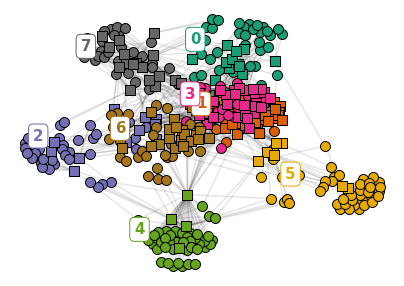

In [682]:
plt.figure(figsize = (7,5))

# plot by cluster color
pos = np.array(list(layout.values()))
np.save('./processed_data/single_cell/ex_pathway_coords.csv', pos)
plot_edges(layout, graph, pos)
plot_nodes(graph, [], pos, cur_labels, unique_clusters, colors, 100)
a = plt.gca()
a.axis('off')
plt.savefig('./pdf_figures/LE_clust_ex.png')

In [683]:
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
SCORES = np.array(scores.loc[g_names]['Ex'])

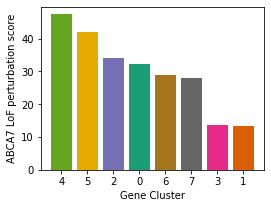

In [690]:
scores = pd.read_csv('./processed_data/single_cell/all_scores.csv', index_col=0)
SCORES = np.array(scores.loc[g_names]['Ex'])

score_sum = np.array([np.sum(np.abs(SCORES[frame['cluster'][frame['is_gene']]==i])) for i in unique_clusters])
plt.figure(figsize = (4,3))

plt.bar(height=score_sum[np.argsort(-1*score_sum)], x = [x.astype(str) for x in unique_clusters[np.argsort(-1*score_sum)]], color = np.array(colors)[np.argsort(-1*score_sum)])
plt.ylabel('ABCA7 LoF perturbation score')
plt.xlabel('Gene Cluster')
plt.savefig('./pdf_figures/ex_clust_bars.png', bbox_inches="tight")

In [271]:
# SCORES = np.array(scores.loc[g_names]['Ex'])
# COL = 'PuOr_r'#C2[i]
# cm = plt.cm.get_cmap(COL, len(SCORES))
# colors = [cm(int(x)) for x in range(len(SCORES))]
# colors = list(np.array(colors))#[np.argsort(SCORES)])

# plt.figure(figsize = (15,10))

# index = np.where(np.invert([graph.nodes[x]['type'] for x in graph.nodes]))[0]
# graph_sub = graph.subgraph(list(index))

# plt.scatter(pos[index,0], pos[index,1], c=SCORES.reshape(-1,1), zorder=5, s=200, cmap='PuOr_r', edgecolor="black", linewidth=1)
# plt.clim(-1.5,1.5)
# #plt.text(pos[index,0][np.argmin(SCORES)], pos[index,1][np.argmin(SCORES)], g_names[np.argmin(SCORES)])
# #plt.colorbar()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# a = plt.gca()
# a.axis('off')
# plt.savefig('./pdf_figures/LE_clust_ex_scores.png')

In [691]:
def get_representative_name_per_cluster(bipartite_mat, colnames_mat, rownames_mat, description_table, cluster):
    genes = set(description_table.loc[description_table['is_gene']&(description_table['cluster']==cluster)]['description'])
    paths = set(description_table.loc[np.invert(description_table['is_gene'])&(description_table['cluster']==cluster)]['description'])
    if len(paths)==0:
        return 'C.'+str(cluster), np.nan, np.nan, np.nan
    else:
        index_col = [x in genes for x in colnames_mat]
        index_row = [x in paths for x in rownames_mat]
        
        #ipdb.set_trace()
    
        sum_internal = np.sum(bipartite_mat[index_row][:,index_col], axis=1)
        sum_external = np.sum(bipartite_mat[index_row][:,np.invert(index_col)], axis=1)
        sum_ratio = sum_internal/(sum_external+sum_internal)
        S = np.argsort(-1*sum_internal)[:5]
        rep_name = rownames_mat[index_row][S]

        return rep_name #'C.'+str(cluster), rep_name.split(' (')[0], sum_internal[S], sum_internal[S]
    

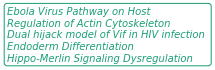

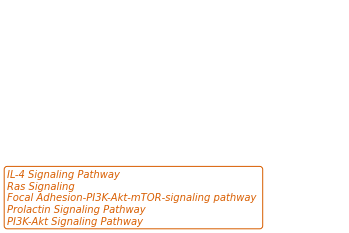

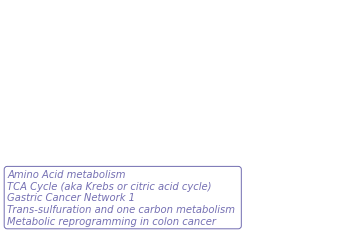

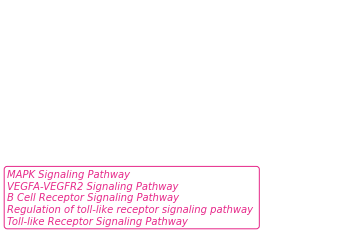

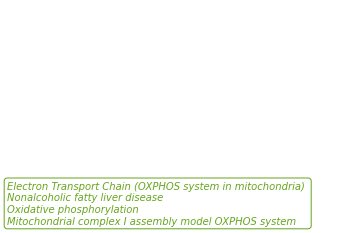

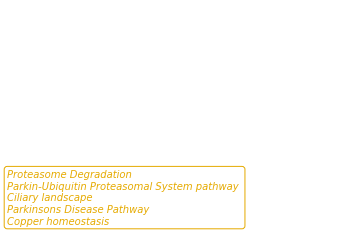

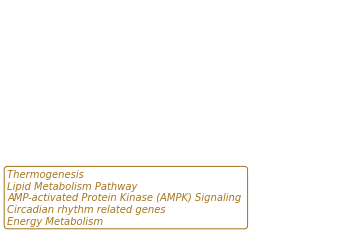

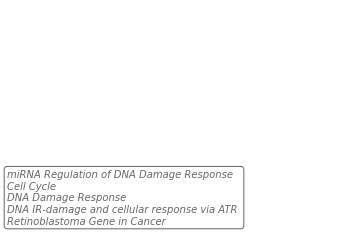

<Figure size 432x288 with 0 Axes>

In [692]:
# get rep names
colnames = np.array(mat_sub.columns)
rownames = np.array(mat_sub.index)

out = [get_representative_name_per_cluster(np.array(mat_sub), colnames, rownames, frame, x) for x in np.unique(frame['cluster'])]


import re
from adjustText import adjust_text

plt.figure(figsize = (1,1))
a = plt.gca()
a.axis('off')
#plot_edges(layout, graph, pos)
texts = []
y = 0
for i, cluster_name in enumerate(unique_clusters):
        index = cur_labels==cluster_name
        x, y = np.mean(pos[index], axis=0)
        
        props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=colors[i])
        temp = [re.split(r' [(]GO|WP| R-',x)[0] for x in out[i]]
        T = ('\n').join(temp)
        plt.text(0, 0, T,  bbox=props, c =colors[i], fontsize = 10, style = "italic")
        
        a = plt.gca()
        a.axis('off')
        plt.savefig('./pdf_figures/LE_clust_ex_names' + str(i) + '.png', bbox_inches="tight")
        plt.figure()
        #y+=0.01
        
#adjust_text(texts)
    



In [ ]:
### mention specific go pathways (lipid-related ones etc)
### show gene and pathway directions (better scoring) for sub-clusters
### keep KL results stringent; say something like; when relax the cutoff, see additional processes, like lipids
### then show targeted lipid analysis after lipidomics
### color genes according to directionality (instead of by sub-cluster)
### show a few representative pathways and their scores as bar plots for each sub-cluster

In [ ]:
### instead of subclustering; show the individual pathways (original ones) based on what subcluster they fall into
### show the genes
### then do additional subclustering analysis for lipid in last figure

In [26]:
def plot_sub_graph(cluster, frame, celltype, out_path, layout, graph, pos, cur_labels, scores):
    unique_clusters = np.unique(frame['cluster'])
    cm = plt.cm.get_cmap('Dark2')
    colors = [cm(int(x)) for x in range(len(unique_clusters))]
    colors2 = list((colors[cluster]))
    colors2 = list((colors[cluster],(0, 0, 0, 0.17)))
    
    plt.figure(figsize = (7,5))
    cur_labels_copy = cur_labels.copy()
    cur_labels_copy[cur_labels_copy!=cluster]=8

    # plot by cluster color
    pos = np.array(list(layout.values()))
    plot_edges(layout, graph, pos)
    plot_nodes(graph, [], pos, cur_labels_copy,list([cluster,8]), colors2, 100)
    a = plt.gca()
    a.axis('off')
    plt.savefig(out_path+str(cluster)+'_highlighted.png')
    
    # plot the genes
    temp = frame[frame['cluster']==cluster]
    temp = scores.loc[temp['description'][temp['is_gene']]]
    temp = temp[np.abs(temp[celltype])>1]
    temp['gene'] = temp.index
    temp=temp.sort_values(by=celltype, ascending = False)

    plt.figure(figsize = (2.5,3))
    sns.barplot(data=temp, x=celltype, y='gene', color=colors[cluster])

    plt.xlabel('-log10(p-value)*sign(log2(FC))')
    plt.ylabel('')
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(out_path+str(cluster)+'_genes.png', bbox_inches="tight")
    
    
    # plot the pathways
    temp = frame[frame['cluster']==cluster]
    T = mat_sub[temp['description'][temp['is_gene']]].loc[temp['description'][np.invert(temp['is_gene'])]]
    temp = np.matmul(T,scores.loc[T.columns][celltype])
    temp = pd.DataFrame(temp)
    temp['pathway'] = [x.split(' WP')[0] for x in np.array(temp.index)]
    temp = temp.sort_values(by=0, ascending=False)
    temp['score'] = temp[0]
    
    plt.figure(figsize = (2.5,3))
    sns.barplot(data=temp[:15], x='score', y='pathway', color=colors[cluster])
    plt.xlabel('score')
    plt.ylabel('')
    sns.despine(top=True, right=True, left=False, bottom=False)

    plt.savefig(out_path+str(cluster)+'_bars.png', bbox_inches="tight")

In [889]:
cluster=6

In [890]:
unique_clusters = np.unique(frame['cluster'])
cm = plt.cm.get_cmap('Dark2')
colors = [cm(int(x)) for x in range(len(unique_clusters))]
colors2 = list((colors[cluster]))

/state/partition1/slurm_tmp/23605775.0.0/ipykernel_2256201/3293262933.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('Dark2')


In [891]:
colors2 = list((colors[cluster],(0, 0, 0, 0.17)))

/state/partition1/slurm_tmp/23605775.0.0/ipykernel_2256201/737365590.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23605775.0.0/ipykernel_2256201/737365590.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


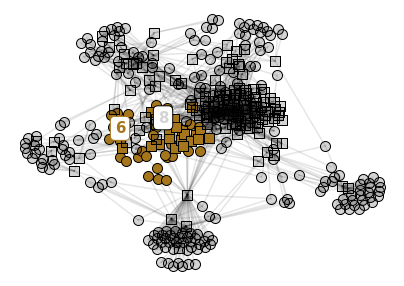

In [892]:
plt.figure(figsize = (7,5))
cur_labels_copy = cur_labels.copy()
cur_labels_copy[cur_labels_copy!=cluster]=8

# plot by cluster color
pos = np.array(list(layout.values()))
np.save('./processed_data/single_cell/ex_pathway_coords.csv', pos)
plot_edges(layout, graph, pos)
plot_nodes(graph, [], pos, cur_labels_copy,list([cluster,8]), colors2, 100)
a = plt.gca()
a.axis('off')
plt.savefig('./pdf_figures/LE_clust'+str(cluster)+'_ex.png')

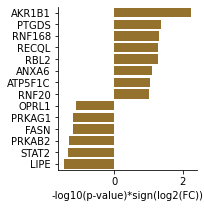

In [893]:
temp = frame[frame['cluster']==cluster]
temp = scores.loc[temp['description'][temp['is_gene']]]
temp = temp[np.abs(temp['Ex'])>1]
temp['gene'] = temp.index
temp=temp.sort_values(by='Ex', ascending = False)

plt.figure(figsize = (2.5,3))
sns.barplot(data=temp, x='Ex', y='gene', color=colors[cluster])

plt.xlabel('-log10(p-value)*sign(log2(FC))')
plt.ylabel('')
sns.despine(top=True, right=True, left=False, bottom=False)

plt.savefig('./pdf_figures/'+str(cluster)+'_genes.png', bbox_inches="tight")

In [894]:
temp = frame[frame['cluster']==cluster]
T = mat_sub[temp['description'][temp['is_gene']]].loc[temp['description'][np.invert(temp['is_gene'])]]

In [895]:
temp = np.matmul(T,scores.loc[T.columns]['Ex'])
#temp = temp/np.sum(T, axis=1)

In [896]:
temp = pd.DataFrame(temp)
temp['pathway'] = [x.split(' WP')[0] for x in np.array(temp.index)]
temp = temp.sort_values(by=0, ascending=False)
temp['score'] = temp[0]

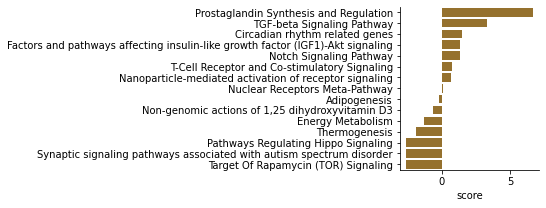

In [897]:
plt.figure(figsize = (2.5,3))
sns.barplot(data=temp[:15], x='score', y='pathway', color=colors[cluster])
plt.xlabel('score')
plt.ylabel('')
sns.despine(top=True, right=True, left=False, bottom=False)

plt.savefig('./pdf_figures/bars'+str(cluster)+'.png', bbox_inches="tight")

In [ ]:
mat_sub2 = (mat_sub.loc[np.array(frame['cluster']==4)[np.invert(frame['is_gene'])],np.array(frame['cluster']==4)[frame['is_gene']]])

frame2, loss_temp = get_kernighan_lin_clusters(None, 25, C, KL_modified, random_labels, unweighted, seed=5, no_progress=False, mat=mat_sub2)
frame2.columns = ['cluster', 'description', 'is_gene']